In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.linear_model import LinearRegression
from sklearn import model_selection, linear_model

# Article I used ~ https://towardsdatascience.com/sobol-indices-to-measure-feature-importance-54cedc3281bc

In [4]:
# === matrices to get two independent samples ===
def create_a(data, N):
    """Creates matrix A."""
    return data.sample(n = N, replace = True).values # replace means elements can be repeated

def create_b(data, N):
    """Creates matrix A."""
    return data.sample(n = N, replace = True).values

# === matrix combination of A and B
def create_combined(data_a, data_b, index_fix): 
    """Creates matrix that's a combination of A and B."""
    # index_fix: index of col to save from matrix A
    data_combined = data_b.copy()
    data_combined[:, index_fix] = data_a[:, index_fix] # sets col index_fix in data_combined to col index_fix of data_a
    return data_combined

In [5]:
def sobol_indice_1st_and_total_order(model_type, model, var_index, data, N):
    """Determines first and total indice."""
    # === Monte Carlo step ===
    # gets combined a and b matrix
    matrix_a = create_a(data, N)
    matrix_b = create_b(data, N)
    matrix_ab = create_combined(matrix_a, matrix_b, var_index)

    # makes predictions using the models
    if model_type == "linear": 
        y_a = model.predict(matrix_a.reshape(-1,1))
        y_b = model.predict(matrix_b.reshape(-1,1))
        y_ab = model.predict(matrix_ab.reshape(-1,1))
    elif model_type == "logistic":
        y_a = model.predict(matrix_a)
        y_b = model.predict(matrix_b)
        y_ab = model.predict(matrix_ab)
    
    # === Calculate indices ===
    # first_order = N * Sum(Y_a * Y_ab) - Sum(Y_a) * Sum(Y_ab)
    first_order = N * np.sum(np.multiply(y_a, y_ab)) - (np.sum(y_a)*np.sum(y_ab))
    
    
    # total = N * Sum(Y_b * Y_ab) - Sum(Y_a)^2
    tot = N * np.sum(np.multiply(y_b, y_ab)) - (np.sum(y_a)**2) # np.multiply - multiples two matrices 
    
    # denom = N * Sum(Y_a^2) - Sum(Y_a)^2
    denom = N * np.sum(y_a**2) - (np.sum(y_a))**2
    
    print(f"first order: {first_order / denom} total: {tot / denom}")
    print(f"first order numerator: {first_order} total numerator: {tot}, denominator: {denom}")
    
    return first_order / denom, (1 - (tot / denom))

intercept: [-3.55271368e-15]
slope: [[2.]]
first order: 0.9203187250996012 total: 1.4183266932270915
first order numerator: -1848.0 total numerator: -2848.000000000001, denominator: -2008.000000000001
first order: 0.7916666666666666 total: 1.3593750000000002
first order numerator: -1823.999999999999 total numerator: -3131.999999999999, denominator: -2303.999999999999


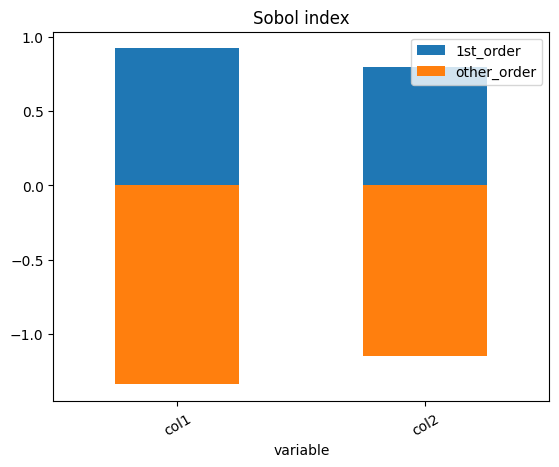

In [6]:
# === Article Example ===
def get_article_data():
    """Get article data."""
    df = pd.read_csv(r"C:\Users\yuana\Documents\Jupyter\sobol_example_data.csv")
    print(df.columns)
    
    df = df.drop(columns="Date")
    rented_count = df["Rented Bike Count"]
    df["Holiday"] = [word == "Holiday" for word in df["Holiday"]]
    df["Functioning Day"] = [word == "checked" for word in df["Functioning Day"]]
    
    return (df, rented_count)

# I realized I do not have the model the article used
"""
d_x, d_y = get_article_data()
X = pd.DataFrame(data=d_x)
Y = pd.DataFrame(data=d_y)
x = X.values.reshape(-1,1)
y = Y.values.reshape(-1,1)
"""

def plot_article_results(model, matrix, N):
    """Find and plot Sobol Indices of article data."""
    first_order = []
    total = []
    
    # iterate through columns of 
    for i in range((matrix.shape[1])):
        results = sobol_indice_1st_and_total_order("linear", model, i, matrix, N)
        first_order.append(results[0])
        total.append(results[1])
        
    df_result = pd.DataFrame({
        "variable": list(matrix.columns),
        "1st_order": first_order,
        "other_order": [tot - first for tot, first in zip(total, first_order)]
    })
    
    df_result.plot(x = "variable", kind = "bar", stacked = True, rot = 30, title = "Sobol index")

# Random numbers I used to see if the code runs and try to understand
d = {"col1": [1,2,3,4], "col2": [5,6,7,8]}
b = {"col1": [2,4,6,8], "col2": [10,12,14,16]}

X = pd.DataFrame(data=d)
Y = pd.DataFrame(data=b)
x = X.values.reshape(-1,1)
y = Y.values.reshape(-1,1)
x, y = np.array(x), np.array(y)


model = LinearRegression().fit(x,y)

print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

plot_article_results(model, X, 3)

In [7]:
# === Functions for Loan Default example ===
def plot_credit_results(model, matrix, N):
    """Find and plot Sobol Indices of credit data."""
    first_order = []
    total = []
    
    # iterate through columns of matrix
    for i in range((matrix.shape[1])):
        results = sobol_indice_1st_and_total_order("logistic", model, i, matrix, N)
        first_order.append(results[0])
        total.append(results[1])
        
    df_result = pd.DataFrame({
        "variable": list(matrix.columns),
        "1st_order": first_order,
        "other_order": [tot - first for tot, first in zip(total, first_order)]
    })
    
    df_result.plot(x = "variable", kind = "bar", stacked = True, rot = 85, title = "Sobol index")

def prob(y_prime, feature, a):
    i = 0
    numer = 0.0
    denom = 0.0

    for x in feature:
        if x[12] == a:
            denom += 1
            if y_prime[i] == 1:
                numer += 1
        i += 1

    if denom != 0:
        return(numer/denom)
    return(0)

Test probabilities: {0: 0.6330935251798561, 1: 0.8378378378378378}


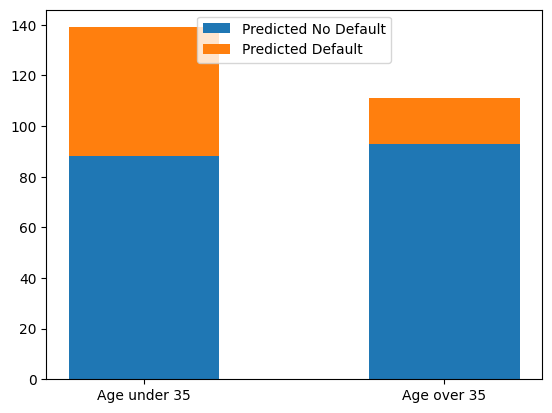

first order: 0.2735847374301539 total: 0.331797286974003
first order numerator: 1334754 total numerator: 1618759, denominator: 4878759
first order: 0.01870011687945562 total: 0.8857628982131529
first order numerator: 94125 total numerator: 4458391, denominator: 5033391
first order: 0.07686507936507936 total: 0.48214285714285715
first order numerator: 387400 total numerator: 2430000, denominator: 5040000
first order: 0.003748973754761899 total: 0.9455091024017166
first order numerator: 18576 total numerator: 4684956, denominator: 4954956
first order: 0.01468330205027275 total: 0.5860326624209805
first order numerator: 73777 total numerator: 2944551, denominator: 5024551
first order: 0.04815708511793449 total: 0.5978363596147273
first order numerator: 239490 total numerator: 2973100, denominator: 4973100
first order: 0.03711160524707332 total: 0.9755044083246602
first order numerator: 189379 total numerator: 4977959, denominator: 5102959
first order: 0.017700542964477154 total: 0.7267854

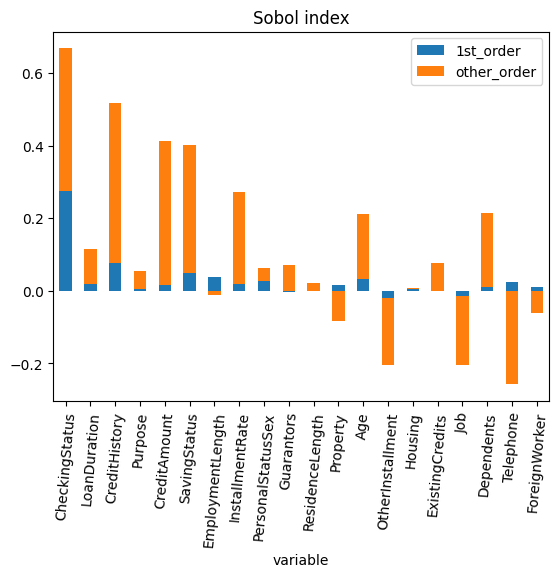

In [17]:
# === Loan Default example ===
np.random.seed(298)

credit_training_features = []
credit_training_labels = []
attributes = []

# Get data
with open("south-german-credit-lab9.csv", "r", newline="") as file:
    data = csv.reader(file)
    attributes = next(data, None) # skip headers
    for row in data:
        features = [int(row[i]) for i in range(0,12)]
        features.append(int(row[12]) >= 35)
        [features.append(int(row[i])) for i in range(13, 20)]
        credit_training_features.append(features)
        credit_training_labels.append(int(row[20]))

# Evaluate data
x_train, x_test, y_train, y_test = model_selection.train_test_split(credit_training_features, credit_training_labels)
logistic_regression_model = linear_model.LogisticRegression(max_iter=5000).fit(x_train, y_train)
y_test_pred = logistic_regression_model.predict(x_test)

# Determine default or not based on age
under_35 = prob(y_test_pred, x_test, False)
over_35 = prob(y_test_pred, x_test, True)
print("Test probabilities: {0: " + str(under_35) + ", 1: " + str(over_35) + "}")
underage_1 = 0
underage_2 = 0
overage_1 = 0
overage_2 = 0
for i in range(len(y_test_pred)):
    if x_test[i][12] and y_test_pred[i] == 1:
        overage_1 += 1
    elif x_test[i][12] and y_test_pred[i] == 2:
        overage_2 += 1
    elif not x_test[i][12] and y_test_pred[i] == 1:
        underage_1 += 1
    elif not x_test[i][12] and y_test_pred[i] == 2:
        underage_2 += 1
age = (
    "Age under 35",
    "Age over 35"
)
weight_counts = {
    "Predicted No Default": np.array([underage_1, overage_1]),
    "Predicted Default": np.array([underage_2, overage_2]),
}
width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(2)
for boolean, weight_count in weight_counts.items():
    p = ax.bar(age, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count
plt.legend(loc="upper center")
plt.show() 

# === Sobol Indices ===
attributes = attributes[0:20]

# turn x_test into dictionary to use with sobol indice functions
x_test_dict = {}
for key in attributes:
    x_test_dict[key] = [] 
for row in x_test:
    for i, val in enumerate(row):
        x_test_dict[attributes[i]].append(val)
X = pd.DataFrame(data=x_test_dict)
plot_credit_results(logistic_regression_model, X, 5000)